 ## Topic Modelling for New York Times Articles
 
 Dataset: https://www.kaggle.com/datasets/aashita/nyt-comments
 
 We need to define the number of topic before hand in LDA
 
 References:
 
 * Link: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
 * Link: https://scikit-learn.org/0.22/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.get_feature_names
 * Link: https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch08/ch08.ipynb
 * Link: https://scikit-learn.org/0.22/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.get_feature_names

In [1]:
# Load Python libaries
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Wendy\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the dataset
df = pd.read_csv ('ArticlesApril2017.csv', encoding='utf-8')

In [3]:
# Inspect the first 5 rows of the dataframe
df.head(3)

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,58def1347c459f24986d7c80,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
1,NaN,58def3237c459f24986d7c84,823,By GAIL COLLINS,article,"And Now, the Dreaded Trump Curse","['United States Politics and Government', 'Tru...",3,OpEd,23,2017-04-01 00:23:58,Unknown,Meet the gang from under the bus.,The New York Times,Op-Ed,https://www.nytimes.com/2017/03/31/opinion/and...
2,NaN,58def9f57c459f24986d7c90,575,By THE EDITORIAL BOARD,article,Venezuela’s Descent Into Dictatorship,"['Venezuela', 'Politics and Government', 'Madu...",3,Editorial,22,2017-04-01 00:53:06,Unknown,A court ruling annulling the legislature’s aut...,The New York Times,Editorial,https://www.nytimes.com/2017/03/31/opinion/ven...


In [4]:
# Remove columns from the article
df = df.drop(columns =['abstract', 'articleID', 'articleWordCount','byline', 'documentType', 'headline','keywords','multimedia','newDesk','printPage','pubDate','sectionName','source','typeOfMaterial','webURL'], axis=1).sample(250)



In [5]:
# Print out the first rows of articles
df.head(3)

,snippet
564,Liberals are discovering what conservatives ha...
53,"Kate Hamill and Eric Tucker, the team behind 2..."
368,"Look closely at this image, stripped of its ca..."


In [6]:
# Remove lower case and punctuation

import re

df['snippet_processed'] = \
df['snippet'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['snippet_processed'] = \
df['snippet_processed'].map(lambda x: x.lower())

# Print out the first rows of dataframe
df['snippet_processed'].head()

564    liberals are discovering what conservatives ha...
53     kate hamill and eric tucker the team behind 20...
368    look closely at this image stripped of its cap...
26     did you happen to notice how much of the show ...
707    moscow and its state-run news outlets are chur...
Name: snippet_processed, dtype: object

## Exploratory Data Analysis

In [7]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


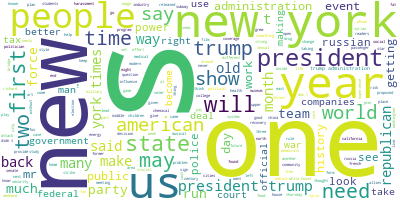

In [8]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the processed articles together.
long_string = ','.join(list(df['snippet_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## Pre-process the data for Latent Dirichlet Allocation


In [9]:
import gensim
from gensim.utils import simple_preprocess
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'but','and'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df.snippet_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['liberals', 'discovering', 'conservatives', 'known', 'years', 'negative', 'energy', 'powerful', 'force']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wendy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
# export pre-processed file as a csv file

df.to_csv('out.csv', index=False)  



In [10]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


## Model training in LDA

In [11]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"us" + 0.008*"care" + 0.006*"states" + 0.006*"president" + '
  '0.006*"new" + 0.006*"york" + 0.004*"thought" + 0.004*"plan" + 0.004*"waive" '
  '+ 0.004*"problems"'),
 (1,
  '0.011*"new" + 0.009*"back" + 0.007*"college" + 0.006*"would" + '
  '0.005*"makes" + 0.005*"deal" + 0.005*"two" + 0.005*"one" + 0.005*"cities" + '
  '0.005*"administration"'),
 (2,
  '0.005*"american" + 0.005*"good" + 0.005*"known" + 0.005*"comes" + '
  '0.005*"next" + 0.005*"shows" + 0.004*"influence" + 0.003*"greeted" + '
  '0.003*"seem" + 0.003*"uncooperative"'),
 (3,
  '0.010*"first" + 0.010*"could" + 0.007*"us" + 0.007*"trump" + '
  '0.005*"companies" + 0.005*"force" + 0.005*"run" + 0.005*"newly" + '
  '0.005*"provide" + 0.005*"food"'),
 (4,
  '0.009*"could" + 0.006*"would" + 0.006*"pay" + 0.006*"world" + '
  '0.006*"century" + 0.006*"much" + 0.006*"mr" + 0.005*"new" + 0.004*"two" + '
  '0.004*"said"'),
 (5,
  '0.012*"one" + 0.008*"trump" + 0.007*"history" + 0.006*"french" + '
  '0.006*"president

## Analyze LDA results

In [12]:
# Use CountVectorizer to create a bag-of-words matrix and set the mazimum document frequency of words to be 10%

from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words ='english' 
                        ,max_df=.1
                        ,max_features = 5000)
X = count.fit_transform(df['snippet'].values)


In [13]:
# Fit LDA estimator to bag of words matrix

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10
                                ,random_state=123
                                ,learning_method = 'batch')
X_topics =lda.fit_transform(X)

In [14]:
# fit lda

X_topics

array([[0.90999538, 0.01000072, 0.01000055, ..., 0.01000014, 0.01000086,
        0.01000146],
       [0.00666667, 0.00666677, 0.0066668 , ..., 0.00666678, 0.00666667,
        0.00666667],
       [0.01      , 0.01000011, 0.0100002 , ..., 0.01      , 0.01      ,
        0.90999957],
       ...,
       [0.01111137, 0.01111152, 0.01111132, ..., 0.0111116 , 0.01111127,
        0.89999754],
       [0.00370389, 0.00370395, 0.96666529, ..., 0.003704  , 0.00370376,
        0.00370371],
       [0.87141255, 0.01428996, 0.01428856, ..., 0.0142883 , 0.01428761,
        0.01428908]])

In [15]:
# View the components of the lda instance 
lda.components_

array([[1.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.1       , 0.1       , 1.10001118, ..., 0.1       , 0.1       ,
        0.1       ],
       [0.1       , 1.10000175, 1.09998939, ..., 0.1       , 0.1       ,
        0.1       ],
       ...,
       [0.1       , 1.09999825, 0.1       , ..., 0.1       , 1.1       ,
        0.1       ],
       [0.1       , 0.1       , 1.09999942, ..., 0.1       , 0.1       ,
        0.1       ],
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ]])

In [16]:
lda.components_.shape

(10, 1786)

In [17]:
# For each topic (a row in the components_), sort the features ascending
# Invert rows with [:,::-1] to make descending
sorting =np.argsort(lda.components_,axis=1)[:,::-1]

# Get the feature names of the vectorizer
feature_names =np.array(count.get_feature_names_out())

In [18]:
pip install mglearn

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Print out the 10 topics:
import mglearn

mglearn.tools.print_topics(topics=range(10),feature_names=feature_names,
                          sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
federal       just          new           trump         president     
administrationnew           8217          president     like          
trump         days          york          mr            team          
health        old           need          making        new           
police        trump         trump         states        war           
state         say           times         events        good          
york          people        president     tax           social        
game          run           right         administrationsecurity      
came          college       know          place         rest          
california    companies     party         state         russia        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
way 

In [43]:
# Look at the 5 most important words for each of the topics

n_top_words = 5
feature_names = count.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))


Topic 1:
federal administration trump health police
Topic 2:
just new days old trump
Topic 3:
new 8217 york need trump
Topic 4:
trump president mr making states
Topic 5:
president like team new war
Topic 6:
way like children tour republican
Topic 7:
said al trump work power
Topic 8:
new york house makes trump
Topic 9:
american time president years election
Topic 10:
world getting people students energy
